# Train a neural network for janken with Keras

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

In [2]:
# Force to use CPU for now
tf.config.set_visible_devices([], 'GPU')

## Create an input pipeline
### Load data

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

### Get the training dataset spec

In [4]:
ds_train_spec = tf.data.DatasetSpec.from_value(ds_train)
ds_train_spec

DatasetSpec((TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), TensorShape([]))

### Build the training pipeline

1. Scale and cast the `uint8` RGB codes to `float32` in `[0, 1]`.
2. Cache the data pre-shuffle (recommended when it fits in memory).
3. Shuffle.
4. Set up batches.
5. Prefetch (an apparent best practice for [performance reasons](https://www.tensorflow.org/guide/data_performance#prefetching)).

In [5]:
def recast(image, label):
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    recast,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Build the test pipeline

Note: caching is done after batching because batches can be the same between epochs?

In [6]:
ds_test = ds_test.map(
    recast,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Create and train the model

In [7]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [9]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
history = model.fit(ds_train, epochs=6, validation_data=ds_test)

Epoch 1/6
20/20 [==============================] - 171s 9s/step - loss: 0.9712 - accuracy: 0.5742 - val_loss: 0.8507 - val_accuracy: 0.5914
Epoch 2/6
20/20 [==============================] - 128s 6s/step - loss: 0.2016 - accuracy: 0.9325 - val_loss: 0.6863 - val_accuracy: 0.7984
Epoch 3/6
20/20 [==============================] - 125s 6s/step - loss: 0.0196 - accuracy: 0.9952 - val_loss: 1.0002 - val_accuracy: 0.7661
Epoch 4/6
20/20 [==============================] - 123s 6s/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 1.2790 - val_accuracy: 0.7446
Epoch 5/6
20/20 [==============================] - 124s 6s/step - loss: 6.4386e-04 - accuracy: 1.0000 - val_loss: 1.7358 - val_accuracy: 0.7285
Epoch 6/6
20/20 [==============================] - 123s 6s/step - loss: 2.3071e-04 - accuracy: 1.0000 - val_loss: 1.8925 - val_accuracy: 0.7285


## Review the history

In [13]:
import matplotlib.pyplot as plt

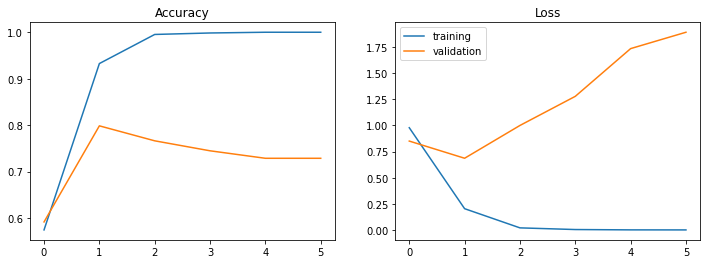

In [24]:
fig, (acc, los) = plt.subplots(1, 2, figsize=(12, 4))

acc.plot(history.epoch, history.history['accuracy'], label='training')
acc.plot(history.epoch, history.history['val_accuracy'], label='validation')
acc.set_title('Accuracy')
los.plot(history.epoch, history.history['loss'], label='training')
los.plot(history.epoch, history.history['val_loss'], label='validation')
los.set_title('Loss')
plt.legend(loc='best')

## Save the model

In [25]:
model.save('janken_take_1.h5')